In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers
x = base_model.output
x = Flatten()(x)  # output of VGG16 to 1D
x = Dense(10, activation='relu')(x)  #connected layer
#x = Dropout(0.5)(x)  # layer for overfitting permit
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
import os
import random
import shutil
from math import floor

# Paths to the original dataset
dataset_dir = '/content/drive/MyDrive'  # Change this to your dataset directory
bone_age_6_dir = os.path.join(dataset_dir, 'bone_age_6')
bone_age_12_dir = os.path.join(dataset_dir, 'bone_age_12')

# Paths for the new split directories
split_dir = '/content/drive/MyDrive/dataset (1)'  # Where to save the split data

train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'validation')
test_dir = os.path.join(split_dir, 'test')

# Function to split data
def split_data(class_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.2, test_size=0.1):
    # List all the images in the class directory
    images = os.listdir(class_dir)
    random.shuffle(images)  # Shuffle the images randomly

    total_images = len(images)
    train_count = floor(train_size * total_images)
    val_count = floor(val_size * total_images)
    test_count = total_images - train_count - val_count  # Remaining for test

    # Create class subdirectories for train, validation, and test if not exist
    class_name = os.path.basename(class_dir)

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Split the data
    for i, img in enumerate(images):
        src_path = os.path.join(class_dir, img)

        if i < train_count:
            dest_dir = os.path.join(train_dir, class_name)
        elif i < train_count + val_count:
            dest_dir = os.path.join(val_dir, class_name)
        else:
            dest_dir = os.path.join(test_dir, class_name)

        # Move the image to the destination directory
        shutil.copy(src_path, dest_dir)

# Split the bone_age_6 images
split_data(bone_age_6_dir, train_dir, val_dir, test_dir)

# Split the bone_age_12 images
split_data(bone_age_12_dir, train_dir, val_dir, test_dir)

print("Data split into train, validation, and test sets.")


Data split into train, validation, and test sets.


In [5]:
train_data_dir = '/content/drive/MyDrive/dataset (1)/train'
valid_data_dir = '/content/drive/MyDrive/dataset (1)/validation'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
valid_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 876 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


In [10]:
# Callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint(
    'best_model_VGG16.keras',
     monitor='val_accuracy',  # Monitors validation accuracy
     save_best_only=True,  # Save only when accuracy improves
     mode='max',  # Maximize accuracy
     verbose=1  # Print update messages
    )

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitors validation loss
    patience=5,  # Stop training after 5 epochs with no improvement
    restore_best_weights=True,  # Restore the best model after stopping
    verbose=1  # Print update messages

    )

#  Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Max number of epochs
    validation_data=val_generator,
    # validation_steps=val_generator.samples // val_generator.batch_size,  # Steps per validation epoch
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4825 - loss: 0.7214
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model_VGG16.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4829 - loss: 0.7206 - val_accuracy: 0.5000 - val_loss: 0.6907
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5338 - loss: 0.6848
Epoch 2: val_accuracy improved from 0.50000 to 0.65600, saving model to best_model_VGG16.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5342 - loss: 0.6848 - val_accuracy: 0.6560 - val_loss: 0.6848
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5194 - loss: 0.6913
Epoch 3: val_accuracy did not improve from 0.65600
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5198 - loss: 0.6913 - val_accuracy: 0.6360 - val_loss: 0.6900
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5636 - loss: 0.6858
Epoch 4: val_accuracy improved from 0.65600 to 0.68400, saving model to best_model_V

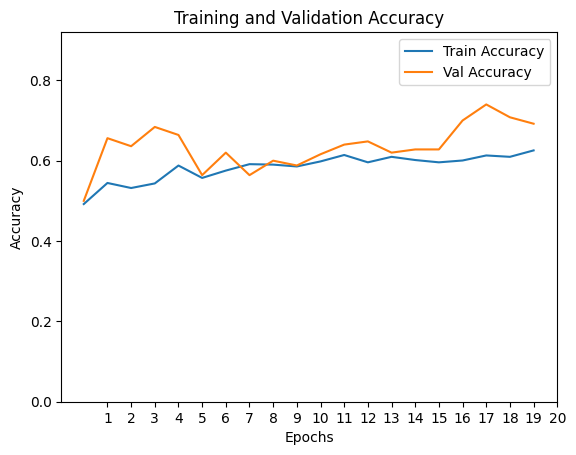

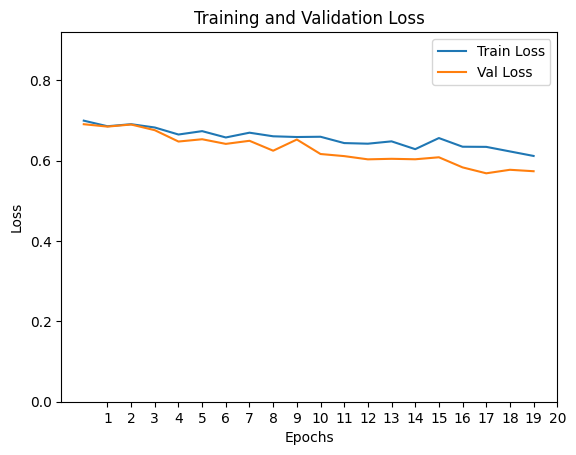

In [11]:
# Plot training and validation accuracy/loss with required changes

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Setting x-axis from 0 to 20 in whole numbers
plt.xticks(range(1, 21, 1))  # Showing epochs as whole numbers from 1 to 20

# Setting y-axis for accuracy from 0.0 to 0.90
plt.ylim(0.00, 0.92)

plt.legend()
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Setting x-axis from 0 to 20 in whole numbers
plt.xticks(range(1, 21, 1))  # Showing epochs as whole numbers from 1 to 20

# Setting y-axis for loss from 0.0 to 0.90
plt.ylim(0.00, 0.92)

plt.legend()
plt.show()

In [12]:
from google.colab import files

# # Download the model
files.download('/content/best_model_VGG16.keras')

# # Found 1002 images belonging to 2 classes.
# # Found 250 images belonging to 2 classes.
# # train {'bone_age_12': 0, 'bone_age_6': 1}
# # valid  {'bone_age_12': 0, 'bone_age_6': 1}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
from tensorflow.keras.models import load_model

# Load the saved model from Google Drive
model_path = '/content/drive/MyDrive/dataset/best_model_VGG16.keras'
model = load_model(model_path)

print("Model loaded successfully!")

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)


Model loaded successfully!
TensorFlow version: 2.17.0
Keras version: 3.4.1


In [14]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Path to the test directory
test_dir = '/content/drive/MyDrive/dataset (1)/test'

# Load and preprocess test images one by one
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale images

# Load images from the test directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,  # One image at a time
    class_mode=None,  # No labels as we just want predictions
    shuffle=False  # Ensure images are processed in order
)

print(test_generator.class_indices)



Found 126 images belonging to 2 classes.
{'bone_age_12': 0, 'bone_age_6': 1}


In [15]:
# Get the filenames of the images in the test directory
filenames = test_generator.filenames

# Predict for each image
for i, file in enumerate(filenames):
    img = test_generator[i]  # Get the image (already preprocessed)
    prediction = model.predict(img)  # Get the prediction

    # Since 'bone_age_12' is class 0 and 'bone_age_6' is class 1:
    if prediction >= 0.5:
        print(f"{file} - Prediction: Bone Age 6 (Confidence: {prediction[0][0]:.2f})")
    else:
        print(f"{file} - Prediction: Bone Age 12 (Confidence: {1 - prediction[0][0]:.2f})")



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
bone_age_12/10240.png - Prediction: Bone Age 12 (Confidence: 0.91)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
bone_age_12/10273.png - Prediction: Bone Age 12 (Confidence: 0.69)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
bone_age_12/10302.png - Prediction: Bone Age 12 (Confidence: 0.57)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
bone_age_12/10413.png - Prediction: Bone Age 12 (Confidence: 0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
bone_age_12/10422.png - Prediction: Bone Age 12 (Confidence: 0.65)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
bone_age_12/10484.png - Prediction: Bone Age 12 (Confidence: 0.92)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
bone_age_12/10555.png - Prediction: Bone Age 12 (Confidence: 0.67)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
bone_age_12/10562.png - Prediction: Bone Age 12 (Confidence: 0.91)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
bone_age_12/10720.png - Prediction: Bone Age 12 (Confidence: 0.63)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
bone_age_12/10867.p

Model loaded successfully!
Found 126 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step


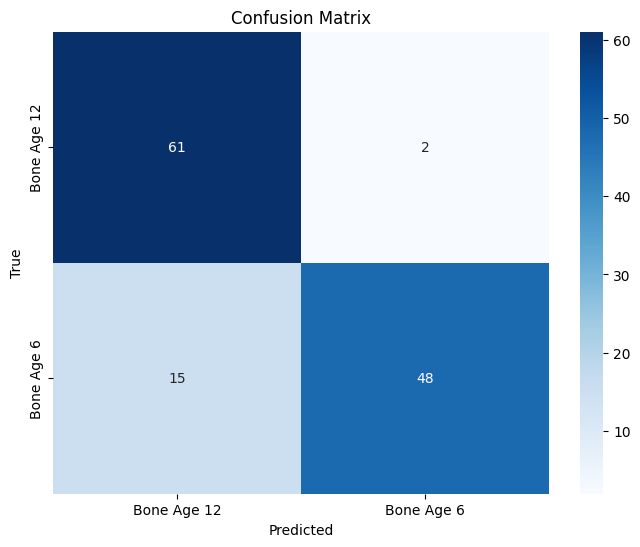

             accuracy  precision  recall  f1-score  support
Bone Age 12      0.97       0.80    0.97      0.88     63.0
Bone Age 6       0.76       0.96    0.76      0.85     63.0


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model_path = '/content/drive/MyDrive/dataset/best_model_VGG16.keras'
model = load_model(model_path)
print("Model loaded successfully!")

# Path to the test directory
test_dir = '/content/drive/MyDrive/dataset (1)/test'

# Load and preprocess test images
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale images

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,  # One image at a time
    class_mode='binary',  # Since we have two classes (bone_age_6 and bone_age_12)
    shuffle=False  # Ensure images are processed in order
)

# Get the filenames and true labels
filenames = test_generator.filenames
true_labels = test_generator.classes  # This gives the actual class of each image

# Predict classes for the images
predictions = model.predict(test_generator)
predicted_classes = (predictions >= 0.5).astype(int).flatten()  # Threshold at 0.5 for binary classification

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Display the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bone Age 12', 'Bone Age 6'], yticklabels=['Bone Age 12', 'Bone Age 6'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy for each class manually
accuracy_bone_age_12 = cm[0, 0] / sum(cm[0, :])  # TP / (TP + FN) for Bone Age 12
accuracy_bone_age_6 = cm[1, 1] / sum(cm[1, :])   # TP / (TP + FN) for Bone Age 6

# Print classification report without macro avg and weighted avg
report = classification_report(true_labels, predicted_classes, target_names=['Bone Age 12', 'Bone Age 6'], output_dict=True)

# Add the accuracy to the report for each class
report['Bone Age 12']['accuracy'] = accuracy_bone_age_12
report['Bone Age 6']['accuracy'] = accuracy_bone_age_6

# Create a DataFrame to display the modified table
import pandas as pd
df = pd.DataFrame(report).transpose()

# Drop the macro avg and weighted avg rows
df = df.drop(['macro avg', 'weighted avg', 'accuracy'])

# Reorder columns to include accuracy at the end
df = df[[ 'accuracy', 'precision', 'recall', 'f1-score', 'support']]

# Round the values to 2 decimal places
df = df.round(2)

# Display the modified classification report
print(df)
